## Visualizando letras populares

## Pacotes

In [47]:
import requests
import json

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
#from scipy.ndimage import gaussian_gradient_magnitude

import urllib.request
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /home/tayna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Funções

In [2]:
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

In [3]:
def pega_musica(artista=None, titulo=None, chave=None):
    
    print("Buscando música \""+titulo+"\" de "+artista+"...")
    
    try:
        response = requests.get("https://api.vagalume.com.br/search.php?art="+artista+"&mus="+titulo+"&extra=alb&apikey={"+chave+"}")
        response.raise_for_status()
    except requests.exceptions.HTTPError as e:
        print(e.response.text)
        
    return response

In [4]:
def songs_to_dataframe(song_dict=None, chave=None):

    song_df = pd.DataFrame(columns=['artista', 'id_artista', 'url_artista',
                                    'titulo', 'letra', 'idioma', 'url', 'id_musica',
                                   'album', 'id_album', 'url_album', 'capa_album', 'ano_album'])

    for song in song_dict:

        titulo = song
        artista = song_dict[song]

        response = pega_musica(artista=artista, titulo=titulo, chave=chave)

        artist_info = response.json()['art']
        artista = artist_info['name']
        id_artista = artist_info['id']
        url_artista = artist_info['url']

        song_info = response.json()['mus'][0]
        titulo = song_info['name']
        letra = song_info['text']
        url = song_info['url']
        id_musica = song_info['id']
        idioma =  idiomas[song_info['lang']]

        album_info = song_info['alb']
        album = album_info['name']
        id_album = album_info['id']
        url_album = album_info['url']
        capa_album = album_info['img']
        ano_album = album_info['year']

        esta_musica = pd.DataFrame([[artista, id_artista, url_artista,
                                     titulo, letra, idioma, url, id_musica,
                                    album, id_album, url_album, capa_album, ano_album]], 
                                   columns=['artista', 'id_artista', 'url_artista',
                                            'titulo', 'letra', 'idioma', 'url', 'id_musica',
                                           'album', 'id_album', 'url_album', 'capa_album', 'ano_album'])
        song_df = pd.concat([song_df, esta_musica])

    song_df.reset_index(inplace=True, drop=True)
    return song_df

In [5]:
def show_wordcloud(data, stopwords = None, title = None):
    text = data

    wordcloud = WordCloud(stopwords = stopwords,
                          collocations=False,
                          background_color='white').generate(text)

    plot_wordcloud(wordcloud, title)

In [42]:
def plot_wordcloud(wordcloud):
    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [7]:
def testa_link(link):
    print(link)
    req = Request(link)
    try:
        response = urlopen(link)
    except HTTPError as e:
        # do something
        print('Código do Erro: ', e.code)
    except URLError as e:
        # do something
        print('Motivo: ', e.reason)
    else:
        # do something
        print('O link funciona!') 

## Dicionários
O Vagalume tem um sistema de números para indicar os idiomas, [confira aqui](https://api.vagalume.com.br/docs/letras/).

In [8]:
idiomas = {
    1:"Português (BR)",
    2:"Inglês",
    3:"Espanhol",
    4:"Francês",
    5:"Alemão",
    6:"Italiano",
    7:"Holandês",
    8:"Japonês",
    9:"Português (PT)",
    999999:"Outros"
}

Nesse dicionário estão os títulos e artistas das letras que queremos visualizar

In [9]:
song_dict = {
    "Mama Africa":"Chico Cesar", 
    "Estado de Poesia":"Chico Cesar"
}

## Aquisição das letras

Buscaremos as músicas com a função *songs_to_dataframe* com minha chave. 

Para criar a sua chave, crie um [login no Vagalume](https://meu.vagalume.com.br) e [siga para esta página](https://auth.vagalume.com.br/settings/api/).

In [10]:
song_df = songs_to_dataframe(song_dict = song_dict, 
                             chave="")

Buscando música "Mama Africa" de Chico Cesar...
Buscando música "Estado de Poesia" de Chico Cesar...


Assim fica o dataframe:

In [11]:
song_df.head()

,artista,id_artista,url_artista,titulo,letra,idioma,url,id_musica,album,id_album,url_album,capa_album,ano_album
0,Chico Cesar,3ade68b5g8fd7eda3,https://www.vagalume.com.br/chico-cesar/,Mama África,"Mama África, \na minha mãe é mãe solteira\ne t...",Português (BR),https://www.vagalume.com.br/chico-cesar/mama-a...,3ade68b6g8dc1fda3,Cuscuz Clã,3ade68b6g7a1bfda3,https://www.vagalume.com.br/chico-cesar/discog...,https://www.vagalume.com.br/chico-cesar/discog...,1996
1,Chico Cesar,3ade68b5g8fd7eda3,https://www.vagalume.com.br/chico-cesar/,Estado de Poesia,Para viver em estado de poesia\nMe entranharia...,Português (BR),https://www.vagalume.com.br/chico-cesar/estado...,3ade68b8g68a480b3,Estado de poesia,3ade68b6g366dfda3,https://www.vagalume.com.br/chico-cesar/discog...,https://www.vagalume.com.br/chico-cesar/discog...,2015


O link de capa do álbum, que será importante para a visualização, não está funcionando. Veja um exemplo:

In [12]:
testa_link(song_df.iloc[0].capa_album)

https://www.vagalume.com.br/chico-cesar/discografia/cuscuz-cla-W125.jpg
Código do Erro:  404


Contudo, ao usar o link do album (*url_album*) consegui encontrar a capa e percebi que do link do álbum para a capa, o que muda é o final da url. Usando disso, então fiz:

In [18]:
song_df['url_album_capa'] = song_df.url_album.str.replace('html','webp')
testa_link(song_df.iloc[0].url_album_capa)

https://www.vagalume.com.br/chico-cesar/discografia/cuscuz-cla.webp
O link funciona!


Então é esse o link que vou usar na visualização

## Visualização das letras

In [116]:
data = song_df.letra.apply(lambda x: x.lower())
data = data.apply(str)
text = data.iloc[1]
#text = " ".join(word for word in data)

In [14]:
letra_musica = song_df.iloc[1].letra
url_capa = song_df.iloc[1].url_album.replace('html','webp')



('../images/3ade68b6g366dfda3.webp',
 <http.client.HTTPMessage at 0x7f1bdf291400>)

In [32]:
def baixa_capa(url_capa, output_file):
    output_path = '../images/'+output_file+'.webp'
    urllib.request.urlretrieve(url_capa, output_path)
    return output_path

In [ ]:
baixa_capa(
    url_capa = song_df.iloc[0].url_album_capa,
    output_file = song_df.iloc[1].id_album
)

In [70]:
def cria_imagem_nuvem(letra, url_capa, stop):
    
    letra = letra.lower()
    capa = baixa_capa(url_capa, 'temp')
    
    mask = np.array(Image.open(capa))

    # Generate wordcloud
    wordcloud = WordCloud(width = 3000, 
                          height = 3000, 
                          random_state=1, 
                          background_color='black', 
                          colormap='rainbow', 
                          collocations=False, 
                          stopwords = stop,
                          mask=mask).generate(letra)
    # Plot
    plot_wordcloud(wordcloud)
    

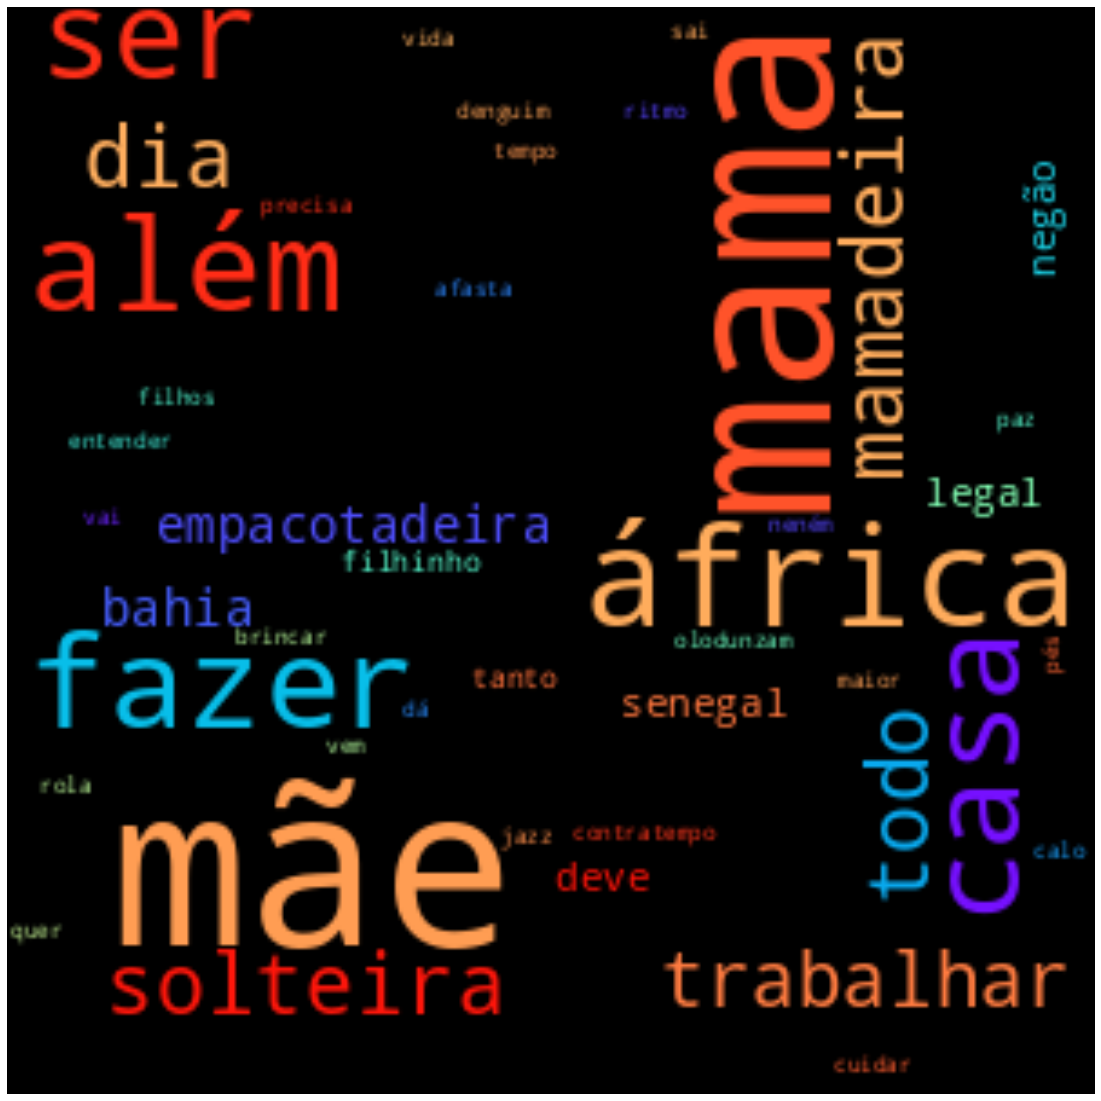

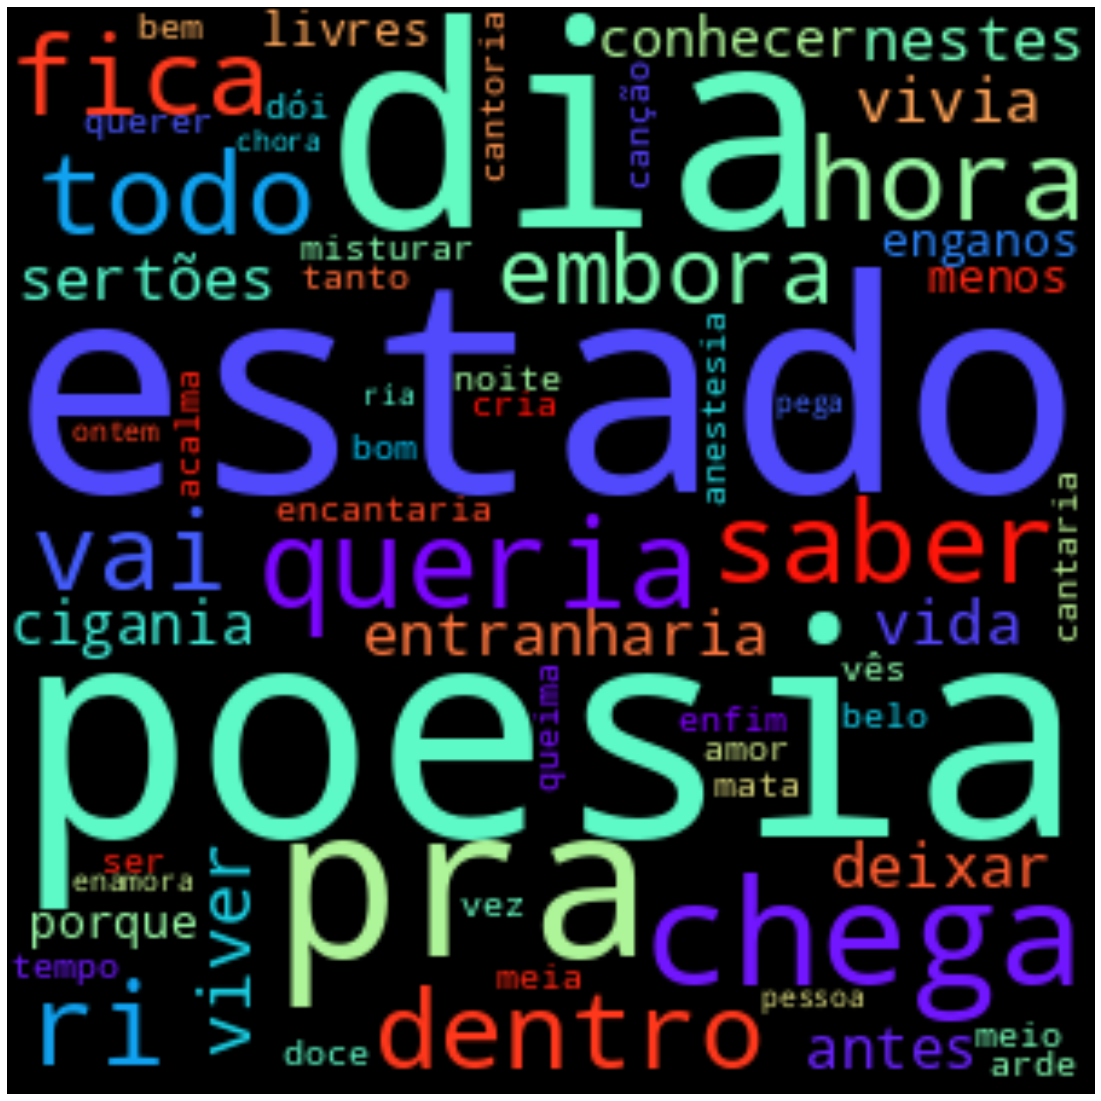

In [71]:
for index, row in song_df.iterrows():
    cria_imagem_nuvem(row.letra, row.url_album_capa, stop)